Plot Network Topology

In [ ]:
from dotenv import load_dotenv
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import re
import os
import sys
import psycopg2
import networkx as nx

load_dotenv()

conn_parameters = {
        "dbname": os.getenv("POSTGRES_DB_NAME", "duilio"),
        "user": os.getenv("POSTGRES_DB_USER", "root"),
        "password": os.getenv("POSTGRES_DB_PASSWORD", "skamasfrevrest"),
        "host": os.getenv("POSTGRES_DB_HOST", "103.0.2.7"),
        "port": int(os.getenv("POSTGRES_DB_PORT", "5433"))
}

conn = psycopg2.connect(**conn_parameters)

# Função para plotar CDF com sombra
def plot_cdf_with_shadow(data_mean, data_hi, data_lo, label):
    sorted_data_mean = np.sort(data_mean)
    #cdf = 100*np.arange(len(sorted_data_mean)) / float(len(sorted_data_mean))
    cdf = np.arange(1, len(sorted_data_mean) + 1) / len(sorted_data_mean) * 100

    
    sorted_data_hi = np.sort(data_hi)
    sorted_data_lo = np.sort(data_lo)
    
    plt.plot(sorted_data_mean, cdf, label=label)
    plt.fill_betweenx(cdf, sorted_data_lo, sorted_data_hi, alpha=0.2)

def get_timeseries_statistics(conn, simulation_id, element_type=None, element_idxs=None, output_name=None):
        # Build dynamic WHERE clauses and parameters
        where_clauses = ["v.simulation_output_id = %s"]
        params = [simulation_id]

        if element_type is not None:
                where_clauses.append("v.extra_info ->> 'element_type' = %s")
                params.append(element_type)
        if element_idxs is not None:
                # Ensure element_idxs is a list or tuple for psycopg2's ANY
                if not isinstance(element_idxs, (list, tuple, np.ndarray)):
                        element_idxs = [element_idxs]
                where_clauses.append("(v.extra_info ->> 'element_index')::int = ANY(%s)")
                params.append(element_idxs)
        if output_name is not None:
                where_clauses.append("v.extra_info ->> 'output' LIKE %s")
                params.append(output_name)

        where_sql = " AND ".join(where_clauses)

        query = f"""
                WITH bus_variables AS (
                SELECT v.variable_id, v.variable_name, v.extra_info
                FROM building_power.variable v
                WHERE {where_sql}
                ),
                per_variable AS (
                SELECT
                        ot.variable_id,
                        average(ot.quantity) AS avg_quantity,
                        percentile(ot.quantity, 0.95) AS p95_quantity,
                        percentile(ot.quantity, 0.05) AS p05_quantity
                FROM building_power.output_timeseries ot
                JOIN bus_variables bv ON ot.variable_id = bv.variable_id
                GROUP BY ot.variable_id
                )
                SELECT
                AVG(avg_quantity) AS mean_quantity,
                AVG(p95_quantity) AS mean_p95_quantity,
                AVG(p05_quantity) AS mean_p05_quantity
                FROM per_variable;"""
        
        df = pd.read_sql_query(
                query,
                conn,
                params=params
        )
        return df

def get_timeseries_data(conn, simulation_id, element_type=None, element_idxs=None, output_name=None):
        # Build dynamic WHERE clauses and parameters
        where_clauses = ["v.simulation_output_id = %s"]
        params = [simulation_id]

        if element_type is not None:
                where_clauses.append("v.extra_info ->> 'element_type' = %s")
                params.append(element_type)
        if element_idxs is not None:
                # Ensure element_idxs is a list or tuple for psycopg2's ANY
                if not isinstance(element_idxs, (list, tuple, np.ndarray)):
                        element_idxs = [element_idxs]
                where_clauses.append("(v.extra_info ->> 'element_index')::int = ANY(%s)")
                params.append(element_idxs)
        if output_name is not None:
                where_clauses.append("v.extra_info ->> 'output' LIKE %s")
                params.append(output_name)

        where_sql = " AND ".join(where_clauses)

        # LOCF = last observation carried forward
        query = f"""
                WITH bus_variables AS (
                SELECT v.variable_id, v.variable_name, v.extra_info
                FROM building_power.variable v
                WHERE {where_sql}
                ),
                per_variable AS (
                SELECT
                        time_bucket('15 minutes', ot.ts) AS bucket,
                        ot.variable_id,
                COALESCE(
                        average(time_weight('locf', ot.ts, ot.quantity)),
                (
                        SELECT quantity
                        FROM building_power.output_timeseries
                        WHERE variable_id = ot.variable_id
                        ORDER BY ts
                        LIMIT 1
                )
        ) AS avg_quantity
                FROM building_power.output_timeseries ot
                JOIN bus_variables bv ON ot.variable_id = bv.variable_id
                GROUP BY bucket, ot.variable_id
                )
                SELECT
                bucket,
                SUM(avg_quantity) AS total_quantity
                FROM per_variable
                GROUP BY bucket
                ORDER BY bucket;"""
        
        df = pd.read_sql_query(
                query,
                conn,
                params=params
        )
        return df

In [2]:
from create_random_network import load_network_from_database

test_name = 'debug_test_heavy'

def get_last_simulation_output_id(test_name, conn):
    """Get the last simulation_output_id for a given test_name"""
   
    cursor = conn.cursor()
    
    # Query to find the most recent simulation with matching test_name
    cursor.execute("""
        SELECT simulation_output_id, parameters
        FROM building_power.simulation_outputs 
        WHERE parameters ->> 'name' = %s 
        ORDER BY started_at DESC 
        LIMIT 1
    """, (test_name,))
    
    result = cursor.fetchone()    
    
    if result:
        return result[0], result[1]
    else:
        return None, None

# Get the last simulation_output_id for the current test_name
simulation_output_id, simulation_parameters = get_last_simulation_output_id(test_name, conn)

if simulation_output_id:
    print(f"Last simulation_output_id for test_name '{test_name}': {simulation_output_id}")
    pandapower_grid_id, net, graph = load_network_from_database(conn_parameters, simulation_parameters['network_id'])
else:
    print(f"No simulation found for test_name '{test_name}'")



Last simulation_output_id for test_name 'debug_test_heavy': 126
Loaded network 'debug_network_3' with 24 buses and 23 connections


/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('f

Plot the simulated network

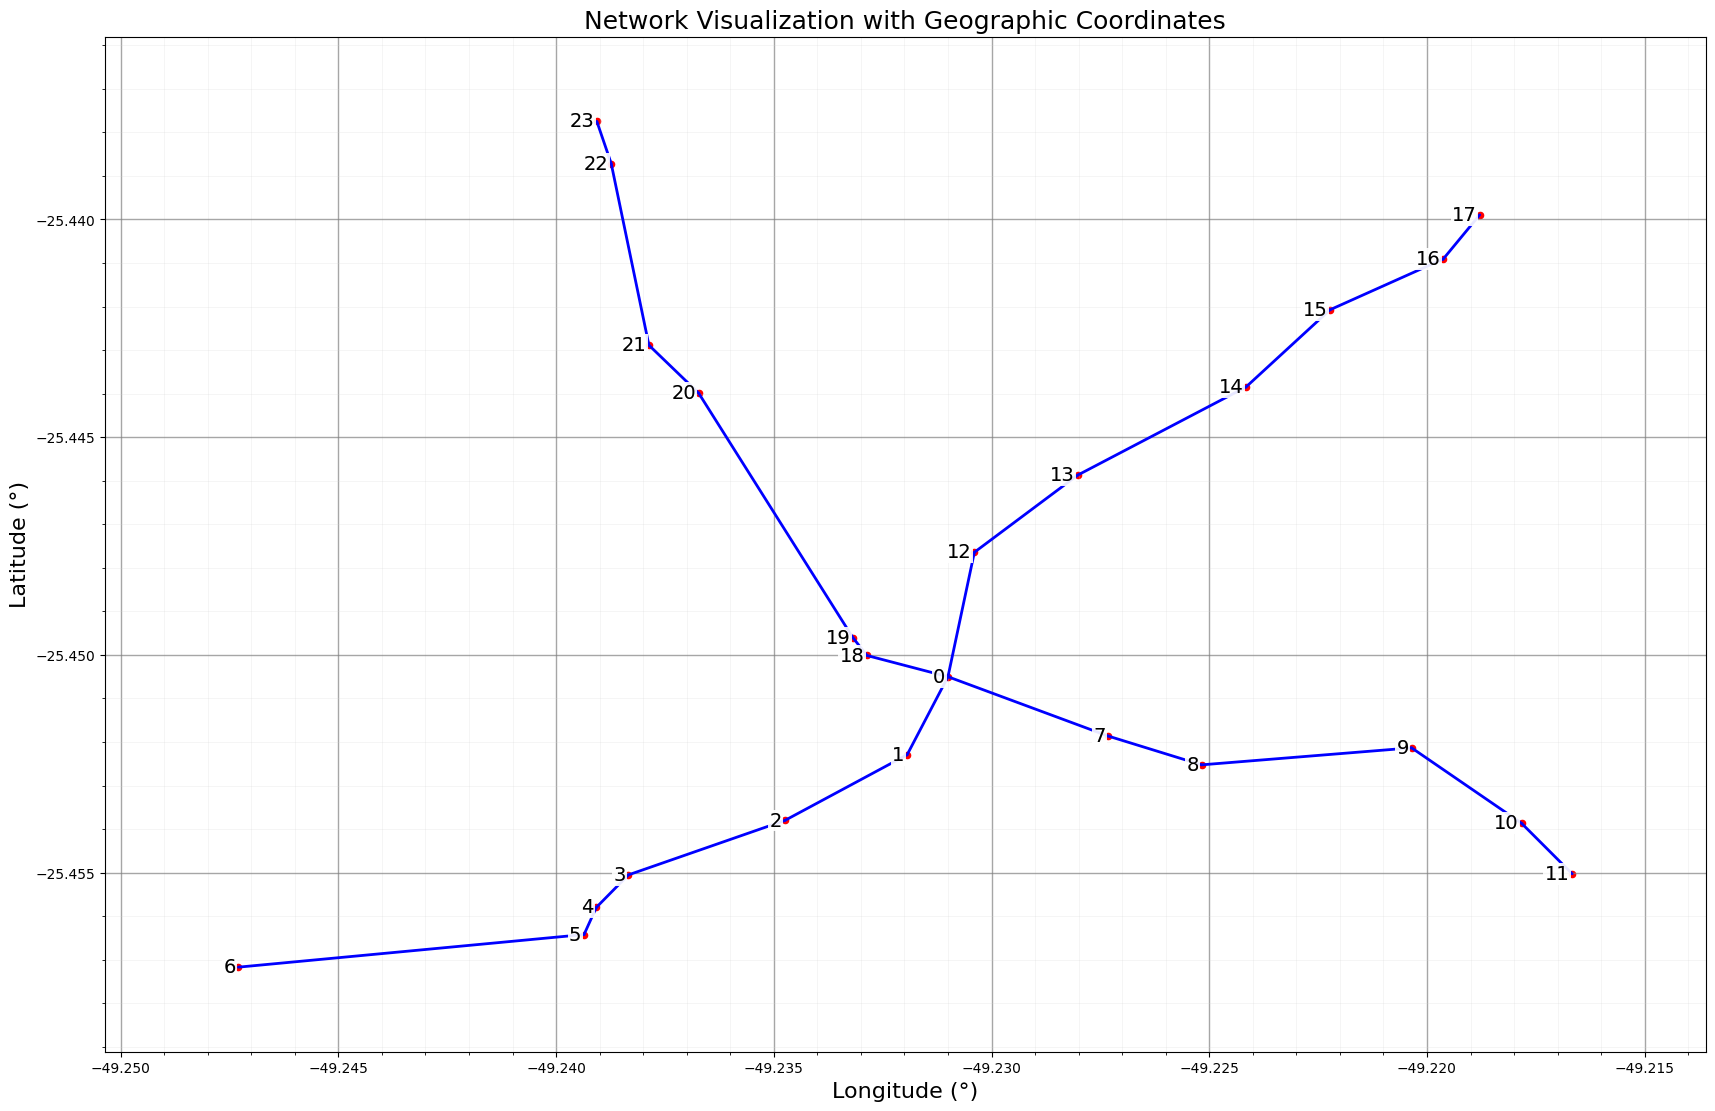

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas
from shapely.geometry import Point, LineString

# 1. Extract bus coordinates
bus_points = [Point(row['x'], row['y']) if not pd.isna(row['x']) and not pd.isna(row['y']) else None 
             for idx, row in net.bus_geodata.iterrows()]

# 2. Create GeoSeries
bus_geo_series = geopandas.GeoSeries(bus_points)

# 3. Create lines from graph edges
line_geometries = []
for u, v, _ in graph.edges(data=True):
    if u < len(bus_points) and v < len(bus_points) and bus_points[u] and bus_points[v]:
        line_geometries.append(LineString([bus_points[u], bus_points[v]]))
    else:
        print(f"Warning: Skipping line between bus {u} and {v}")

# 4. Create GeoDataFrame
line_geo_df = geopandas.GeoDataFrame({'geometry': line_geometries})

# 5. Create figure with large size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot network
line_geo_df.plot(ax=ax, color='blue', linewidth=2)
bus_geo_series.plot(ax=ax, color='red', markersize=20)

# Get bounds
valid_points = [p for p in bus_points if p]
if valid_points:
    min_x = min(p.x for p in valid_points)
    max_x = max(p.x for p in valid_points)
    min_y = min(p.y for p in valid_points)
    max_y = max(p.y for p in valid_points)
    
    # Add padding
    pad_x = (max_x - min_x) * 0.1
    pad_y = (max_y - min_y) * 0.1
    min_x -= pad_x
    max_x += pad_x
    min_y -= pad_y
    max_y += pad_y
    
    # Check if coordinates are likely lat/lon (small values around -180 to 180 for longitude and -90 to 90 for latitude)
    is_latlon = (min_x > -180 and max_x < 180 and min_y > -90 and max_y < 90)
    
    if is_latlon:
        # For lat/lon coordinates, use 0.001° grid (approx. 111m at equator) and 0.005° labels
        # 0.001° is roughly 111 meters at the equator
        minor_ticks_x = np.arange(np.floor(min_x/0.001)*0.001, np.ceil(max_x/0.001)*0.001, 0.001)
        minor_ticks_y = np.arange(np.floor(min_y/0.001)*0.001, np.ceil(max_y/0.001)*0.001, 0.001)
        major_ticks_x = np.arange(np.floor(min_x/0.005)*0.005, np.ceil(max_x/0.005)*0.005, 0.005)
        major_ticks_y = np.arange(np.floor(min_y/0.005)*0.005, np.ceil(max_y/0.005)*0.005, 0.005)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(minor_ticks_y, minor=True)
        
        # Grid styling
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks (with less frequent labels for readability)
        # Show fewer labels to avoid overcrowding
        # for i, x in enumerate(major_ticks_x):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(x, min_y - pad_y*0.3, f'{x:.4f}°', 
        #                ha='center', va='top', fontsize=10, color='black')
        # for i, y in enumerate(major_ticks_y):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(min_x - pad_x*0.3, y, f'{y:.4f}°', 
        #                ha='right', va='center', fontsize=10, color='black')
                       
        plot_title = "Network Visualization with Geographic Coordinates"
        x_label = "Longitude (°)"
        y_label = "Latitude (°)"
    else:
        # Assume meters format (original code)
        # Create 50m grid (minor) and 100m ticks (major)
        major_ticks = np.arange(np.floor(min_x/100)*100, np.ceil(max_x/100)*100, 100)
        minor_ticks = np.arange(np.floor(min_x/50)*50, np.ceil(max_x/50)*50, 50)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(minor_ticks, minor=True)
        
        # Grid styling - major (100m) is bolder
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks
        for x in major_ticks:
            ax.text(x, min_y - pad_y*0.3, f'{x:.0f}m', 
                   ha='center', va='top', fontsize=12, color='black')
        for y in major_ticks:
            ax.text(min_x - pad_x*0.3, y, f'{y:.0f}m', 
                   ha='right', va='center', fontsize=12, color='black')
                   
        plot_title = "Network Visualization with 50m Grid (100m Labels)"
        x_label = "X Coordinate (m)"
        y_label = "Y Coordinate (m)"

# Annotate buses

# Set axis limits to only span the network area (with a small padding)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Make the plot narrower and shorter
fig.set_size_inches(17, 17)

for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set the plot title using ax.set_title instead of plt.title to avoid layout issues
ax.set_title(plot_title, fontsize=18)

# Remove extra whitespace around the plot by tightening the layout
plt.tight_layout()
plt.xlabel(x_label, fontsize=16)
plt.ylabel(y_label, fontsize=16)
#ax.set_aspect('equal')

# Save as PDF
plt.savefig('network_visualization_clean_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

Plot network power

In [ ]:
# Query transformer low voltage power time series for the last simulation
df_trafo_lv = get_timeseries_data(
    conn,
    simulation_output_id,
    element_type='transformer',
    output_name='P_%_lv[MW]'
)

if df_trafo_lv.empty:
    print("No transformer low voltage power data found for this simulation.")
else:
    df_trafo_lv['bucket'] = pd.to_datetime(df_trafo_lv['bucket'])
    plt.figure(figsize=(12, 5))
    plt.plot(df_trafo_lv['bucket'], df_trafo_lv['total_quantity'] * 1000, marker='o')
    plt.title('Transformer Low Voltage Power (Sum of All Transformers)')
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Power [kW]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_255185/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


Power Generation/Use

/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(
/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(
/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(
/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not 

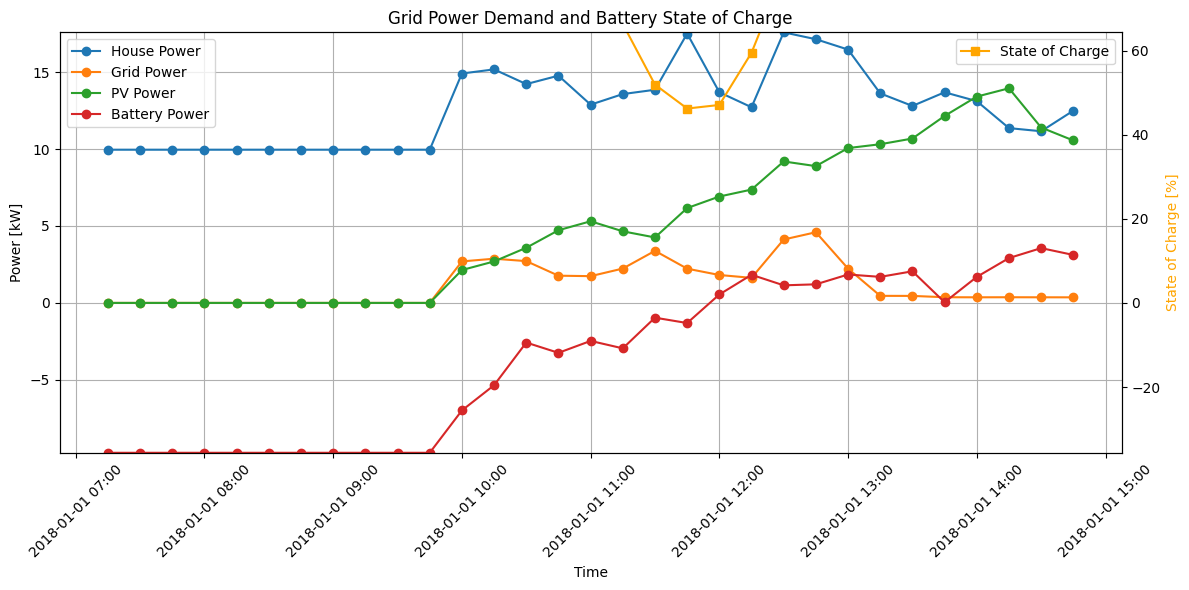

In [ ]:

energy_outputs = [
    ('Power[kW]', 'House Power', 1),
    ('P_%_load[MW]', 'Grid Power', 1000),    
    ('PVPowerGeneration[MW]', 'PV Power', 1000),
    ('BatteryPower[MW]', 'Battery Power', 1000),
]
# Create a second y-axis for SOC
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot power data on the left y-axis
for output_name, label, multiplier in energy_outputs:
    df_energy = get_timeseries_data(
        conn,
        simulation_output_id,
        output_name=output_name
    )
    if not df_energy.empty:
        df_energy['bucket'] = pd.to_datetime(df_energy['bucket'])
        ax1.plot(df_energy['bucket'], df_energy['total_quantity'] * multiplier, marker='o', label=label)
    else:
        print(f"No data found for {label}")

# Plot SOC on the right y-axis
df_soc = get_timeseries_data(
    conn,
    simulation_output_id,
    output_name='SOC[percent]'
)
if not df_soc.empty:
    df_soc['bucket'] = pd.to_datetime(df_soc['bucket'])
    ax2.plot(df_soc['bucket'], df_soc['total_quantity'], marker='s', color='orange', label='State of Charge')
else:
    print("No data found for State of Charge")

# Configure axes
ax1.set_xlabel('Time')
ax1.set_ylabel('Power [kW]', color='black')
ax2.set_ylabel('State of Charge [%]', color='orange')
ax2.set_ylim(0, 100)
# Adjust SOC y-axis to show full range with some padding
soc_min = df_soc['total_quantity'].min()
soc_max = df_soc['total_quantity'].max()
soc_range = soc_max - soc_min
padding = soc_range * 0.1 if soc_range > 0 else 5
# Calculate power range for aligning zeros
power_values = []
for output_name, label, multiplier in energy_outputs:
    df_energy = get_timeseries_data(conn, simulation_output_id, output_name=output_name)
    if not df_energy.empty:
        power_values.extend((df_energy['total_quantity'] * multiplier).tolist())

if power_values:
    min_power = min(power_values)
    max_power = max(power_values)
    if max_power > min_power:
        rel_zero = (0 - min_power) / (max_power - min_power)
        ylim_min2 = 0 - rel_zero * 100
        ylim_max2 = 100 - rel_zero * 100
        ax1.set_ylim(min_power, max_power)
        ax2.set_ylim(ylim_min2, ylim_max2)
    else:
        ax1.set_ylim(min_power*1.05, max_power*1.05)
        ax2.set_ylim(0, 100)
else:
    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 100)
# Set both axes to start from zero
#ax1.set_ylim(0, None)  # Power axis starts from zero
ax2.set_ylim(0, 100)   # SOC axis from 0 to 100%
# Format x-axis
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(True)
plt.title('Grid Power Demand and Battery State of Charge')
plt.tight_layout()
plt.show()

Check solar irradiation

/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


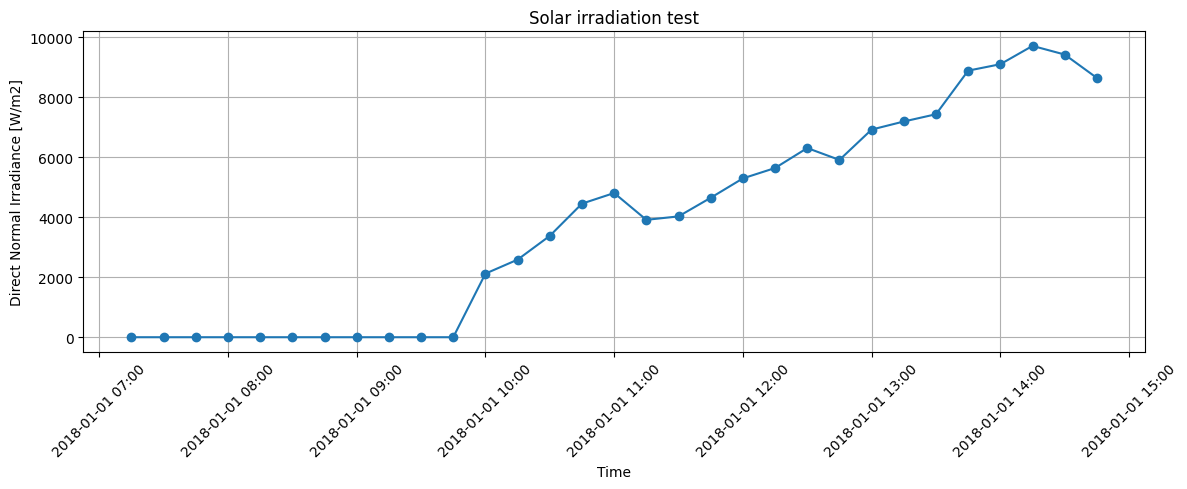

In [ ]:
# Query transformer low voltage power time series for the last simulation
df_solar = get_timeseries_data(
    conn,
    simulation_output_id,
    element_type='solarirradiation',
    output_name='DNI[W/m2]'
)

if df_solar.empty:
    print("No solar data found for this simulation.")
else:
    df_solar['bucket'] = pd.to_datetime(df_solar['bucket'])
    plt.figure(figsize=(12, 5))
    plt.plot(df_solar['bucket'], df_solar['total_quantity'] , marker='o')
    plt.title('Solar irradiation test')
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Direct Normal Irradiance [W/m2]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()





Tensão nas barras

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Collect all bus descendants from trafos ---
lv_buses = []

for idx, trafo in net.trafo.iterrows():
    lv_bus = trafo["lv_bus"]
    descendants = list(nx.descendants(graph, lv_bus))
    lv_buses.extend(descendants)

lv_buses = list(set(lv_buses))  # remove duplicates

# --- Step 2: Query Vm_[pu] for each bus via get_timeseries_data ---
all_bus_data = {}

voltage_df, _ = get_timeseries_data(
            conn,
            simulation_output_id,
            element_type="bus",
            element_idxs=lv_buses,
            output_name="%Bus-%-Vm_%[pu]"
        )

# for bus in lv_buses:
#     # each bus typically has Vm_a[pu], Vm_b[pu], Vm_c[pu]
#     for phase in ["a", "b", "c"]:
#         output_name = f"{bus}-Vm_{phase}[pu]"
#         df, _ = get_timeseries_data(
#             conn,
#             simulation_output_id,
#             element_type="bus",
#             element_idxs=bus,
#             output_name=output_name
#         )

#         if not df.empty:
#             all_bus_data[f"{bus}-Vm_{phase}[pu]"] = df["total_quantity"].values

# --- Step 3: Organize into DataFrame ---
#voltage_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_bus_data.items()]))

# --- Step 4: Compute statistics ---
stats_df = pd.DataFrame({
    "Average": voltage_df.mean(),
    "Max": voltage_df.max(),
    "Min": voltage_df.min()
})

average_vector = stats_df["Average"].values
max_vector = stats_df["Max"].values
min_vector = stats_df["Min"].values

# --- Step 6: Plot ---
plot_cdf_with_shadow(average_vector, max_vector, min_vector, "Bus Voltage Magnitude [pu]")

plt.axvline(x=0.93, color="red", linestyle="--", linewidth=1.5, label="Prodist Minimum Bound")
plt.axvline(x=1.05, color="red", linestyle="--", linewidth=1.5, label="Prodist Maximum Bound")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=False, fontsize=12)
plt.tight_layout()
plt.show()


/tmp/ipykernel_14530/1729745442.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


AttributeError: 'str' object has no attribute 'mean'

Perda de potência ativa nas barras

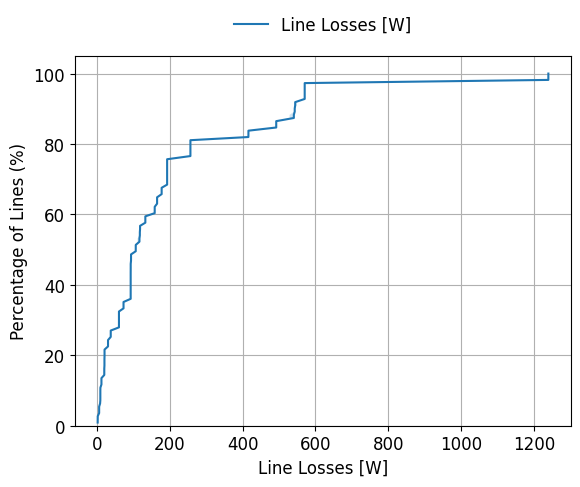

In [ ]:

# Filter columns that match the Bus voltage magnitude pattern
loss_columns = [col for col in df.columns if re.search(r"Line-\d+-Pl_[a|b|c]\[MW\]$", col)]
loss_df = df[loss_columns]*1e6

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': loss_df.mean(),
    'Max': loss_df.max(),
    'Min': loss_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Losses [W]')

plt.xlabel('Line Losses [W]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Corrente de Neutro

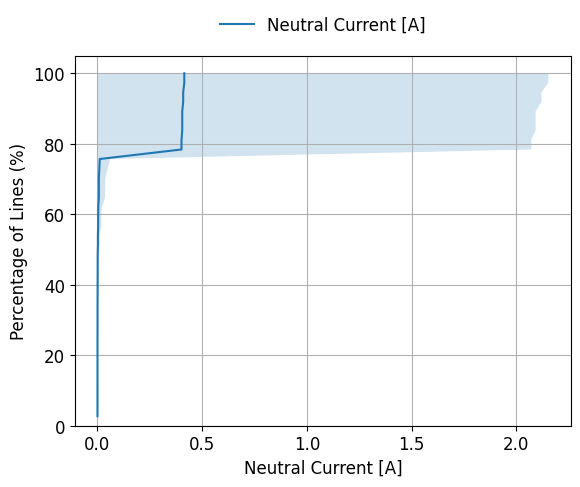

In [ ]:
# Filter columns that match the Bus voltage magnitude pattern
neutral_current_columns = [col for col in df.columns if re.search(r"Line-\d+-I_n_from\[kA\]$", col)]
neutral_current_df = df[neutral_current_columns]*1e3

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': neutral_current_df.mean(),
    'Max': neutral_current_df.max(),
    'Min': neutral_current_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Neutral Current [A]')

plt.xlabel('Neutral Current [A]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Line Loading

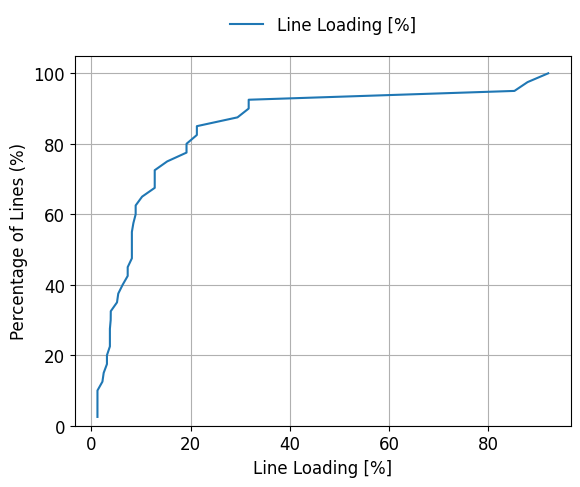

In [ ]:
# Filter columns that match the Bus voltage magnitude pattern
line_loading_columns = [col for col in df.columns if re.search(r"Loading\[%\]$", col)]
line_loading_df = df[line_loading_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': line_loading_df.mean(),
    'Max': line_loading_df.max(),
    'Min': line_loading_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Loading [%]')

plt.xlabel('Line Loading [%]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Desbalanceamento de Barramentos

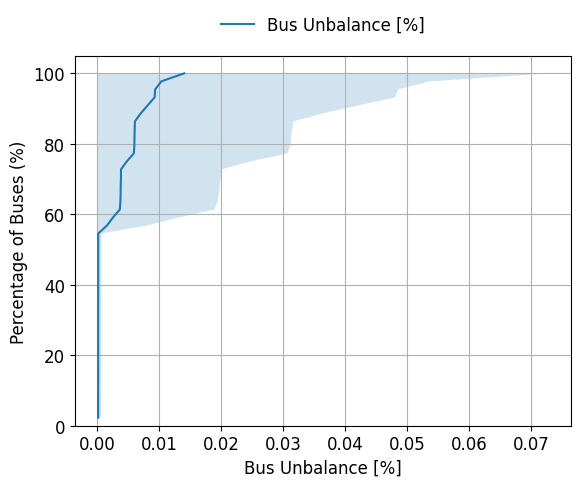

In [ ]:

# Filter columns that match the Bus voltage magnitude pattern
unbalance_columns = [col for col in df.columns if re.search(r"Bus-\d+-Unbalance\[%\]$", col)]
unbalance_df = df[unbalance_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': unbalance_df.mean(),
    'Max': unbalance_df.max(),
    'Min': unbalance_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Unbalance [%]')

plt.xlabel('Bus Unbalance [%]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Total Power

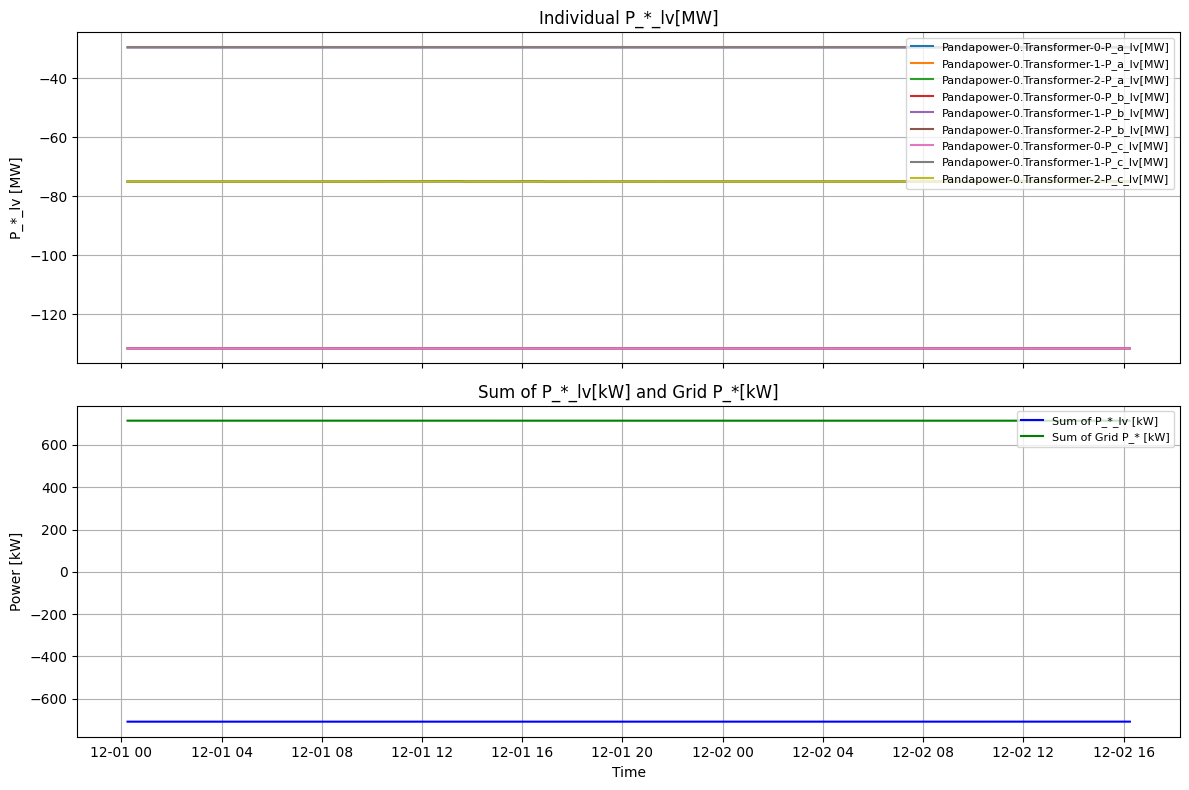

In [ ]:
# Filter columns for P_*_hv[MW] and P_*[MW]
p_hv_columns = [col for col in df.columns if re.search(r"Pandapower-0.Transformer-\d+-P_[a|b|c]_lv\[MW\]$", col)]
p_grid_columns = [col for col in df.columns if re.search(r"Pandapower-0.ExternalGrid-\d+-P_[a|b|c]\[MW\]$", col)]

# DataFrames for the filtered columns
p_hv_df = df[p_hv_columns]
p_grid_df = df[p_grid_columns]

# Calculate the sum of P_*_hv[MW] and P_*[MW]
p_hv_sum = p_hv_df.sum(axis=1)
p_grid_sum = p_grid_df.sum(axis=1)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First subplot: Plot every P_*_hv[MW]
for col in p_hv_columns:
    axes[0].plot(df.index, df[col]*1000, label=col)
axes[0].set_ylabel('P_*_lv [MW]')
axes[0].set_title('Individual P_*_lv[MW]')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True)

# Second subplot: Plot the sum of P_*_hv[MW] and grid P_*[MW]
axes[1].plot(df.index, p_hv_sum*1000, label='Sum of P_*_lv [kW]', color='blue')
axes[1].plot(df.index, p_grid_sum*1000, label='Sum of Grid P_* [kW]', color='green')
axes[1].set_ylabel('Power [kW]')
axes[1].set_title('Sum of P_*_lv[kW] and Grid P_*[kW]')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True)

# Finalize plot
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Test power consumption data

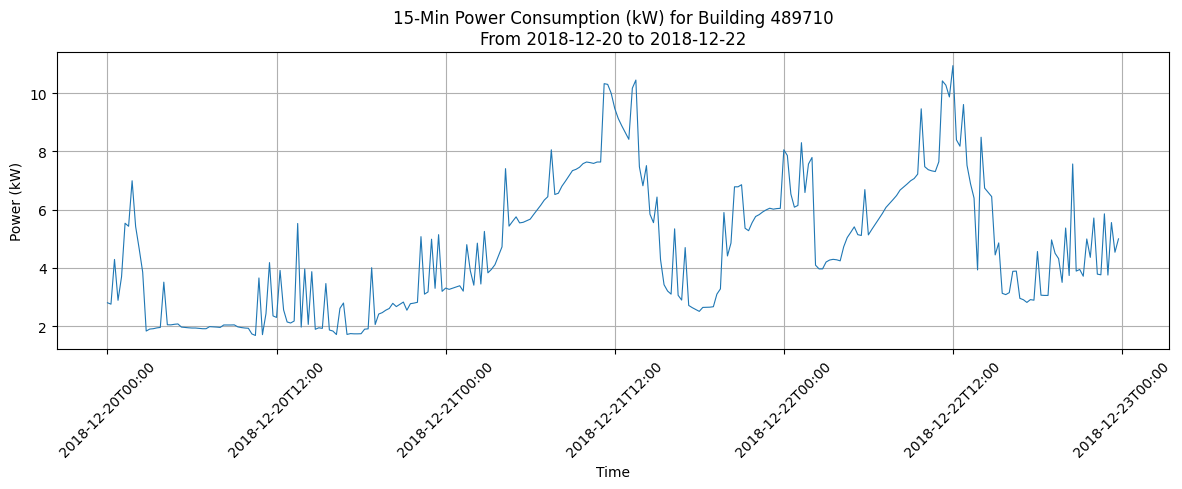

In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import timedelta
import matplotlib.dates as mdates

def plot_random_power_15min(bldg_id: int, num_days: int):
    # Connection config
    conn = psycopg2.connect(
        dbname="duilio",
        user="root",
        password="skamasfrevrest",
        host="103.0.1.37",
        port=5433  # or your port
    )
    cursor = conn.cursor()

    # Step 1: Get available daily buckets using TimescaleDB's time_bucket
    cursor.execute("""
        SELECT DISTINCT time_bucket('1 day', sample_time) AS day
        FROM building_power.building_power
        WHERE bldg_id = %s
        ORDER BY day
    """, (bldg_id,))
    days = [row[0] for row in cursor.fetchall()]
    
    if len(days) < num_days:
        print(f"Not enough days available (found {len(days)}, need {num_days}).")
        conn.close()
        return

    # Step 2: Pick a random start day
    start_idx = random.randint(0, len(days) - num_days)
    start_day = days[start_idx]
    end_day = start_day + timedelta(days=num_days)

    # Step 3: Fetch 15-min data for that period
    cursor.execute("""
        SELECT sample_time, electricity_total_energy_consumption / 0.25 AS power_kw
        FROM building_power.building_power
        WHERE bldg_id = %s
          AND sample_time >= %s
          AND sample_time < %s
          AND electricity_total_energy_consumption IS NOT NULL
        ORDER BY sample_time
    """, (bldg_id, start_day, end_day))
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        print("No data found in selected time range.")
        return

    # Step 4: Plot
    df = pd.DataFrame(rows, columns=["sample_time", "power_kw"])
    df["sample_time"] = pd.to_datetime(df["sample_time"])

    plt.figure(figsize=(12, 5))
    plt.plot(df["sample_time"], df["power_kw"], linewidth=0.8)
    plt.title(f"15-Min Power Consumption (kW) for Building {bldg_id}\nFrom {start_day.date()} to {(end_day - timedelta(days=1)).date()}")
    plt.xlabel("Time")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M'))
    plt.tight_layout()
    plt.show()

# Example usage:
plot_random_power_15min(bldg_id=489710, num_days=3)


CDF das potências do banco de dados


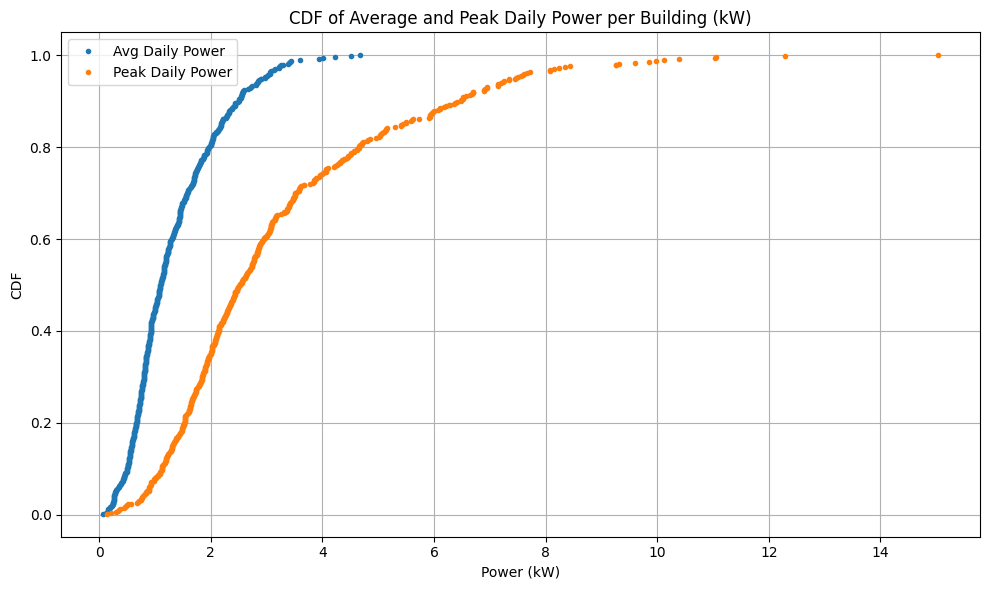

In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_cdf_avg_power():
    # Connect to the database
    conn = psycopg2.connect(
        dbname="duilio",
        user="root",
        password="skamasfrevrest",
        host="103.0.1.37",
        port=5433  # or your port
    )
    cursor = conn.cursor()

    # Step 1: Query average daily energy per building
    cursor.execute("""
        SELECT 
        bldg_id,
        AVG(electricity_total_energy_consumption) / 24.0 AS avg_daily_power_kw,
        MAX(electricity_total_energy_consumption) / 24.0 AS peak_daily_power_kw
        FROM building_power.daily_energy
        WHERE electricity_total_energy_consumption IS NOT NULL
        GROUP BY bldg_id;
    """)
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        print("No data returned.")
        return

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(rows, columns=["bldg_id", "avg_daily_power_kw", "peak_daily_power_kw"])

    # Step 3: Prepare data for CDF
    sorted_avg = np.sort(df["avg_daily_power_kw"])
    cdf_avg = np.arange(1, len(sorted_avg) + 1) / len(sorted_avg)

    sorted_peak = np.sort(df["peak_daily_power_kw"].dropna())
    cdf_peak = np.arange(1, len(sorted_peak) + 1) / len(sorted_peak)

    # Step 2: Plot both CDFs
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_avg, cdf_avg, marker='.', linestyle='none', label="Avg Daily Power")
    plt.plot(sorted_peak, cdf_peak, marker='.', linestyle='none', label="Peak Daily Power")
    plt.title("CDF of Average and Peak Daily Power per Building (kW)")
    plt.xlabel("Power (kW)")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_cdf_avg_power()


In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_total_network_power(simulation_output_id):
    """
    Plot the total power consumption of the network based on P_a[MW], P_b[MW], and P_c[MW]
    of all low voltage buses connected to transformers.
    
    Args:
        simulation_output_id (int): The ID of the simulation output to analyze
    """
    # Connect to the database
    conn_parameters = {
        'dbname': "duilio",
        'user': "root",
        'password': "skamasfrevrest",
        'host': "103.0.1.37",
        'port': 5433
    }
    
    conn = psycopg2.connect(**conn_parameters)
    cursor = conn.cursor()
    
    # Direct SQL query to get time series data for P_a[MW], P_b[MW], and P_c[MW] for all buses
    cursor.execute("""
        WITH bus_power_vars AS (
            SELECT v.variable_id, v.variable_name,
                   CASE 
                       WHEN v.variable_name LIKE '%P_a[MW]' THEN 'a'
                       WHEN v.variable_name LIKE '%P_b[MW]' THEN 'b'
                       WHEN v.variable_name LIKE '%P_c[MW]' THEN 'c'
                       ELSE NULL
                   END AS phase
            FROM building_power.variable v
            WHERE v.simulation_output_id = %s
              AND v.variable_name LIKE 'Pandapower-0.Bus-%'
              AND v.variable_name LIKE '%%[MW]'
              AND (v.variable_name LIKE '%%P_a[MW]' OR 
                   v.variable_name LIKE '%%P_b[MW]' OR 
                   v.variable_name LIKE '%%P_c[MW]')
        ),
        timeseries_data AS (
            SELECT 
                ts,
                bpv.phase,
                SUM(ots.quantity) AS total_power_mw
            FROM building_power.output_timeseries ots
            JOIN bus_power_vars bpv ON ots.variable_id = bpv.variable_id
            GROUP BY ts, bpv.phase
            ORDER BY ts, bpv.phase
        )
        SELECT 
            ts,
            MAX(CASE WHEN phase = 'a' THEN total_power_mw ELSE 0 END) AS phase_a_mw,
            MAX(CASE WHEN phase = 'b' THEN total_power_mw ELSE 0 END) AS phase_b_mw,
            MAX(CASE WHEN phase = 'c' THEN total_power_mw ELSE 0 END) AS phase_c_mw
        FROM timeseries_data
        GROUP BY ts
        ORDER BY ts
    """, (simulation_output_id,))
    
    rows = cursor.fetchall()
    
    if not rows:
        print(f"No time series data found for simulation_output_id {simulation_output_id}")
        conn.close()
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=['ts', 'phase_a_mw', 'phase_b_mw', 'phase_c_mw'])
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Calculate total power across all phases
    df['total_mw'] = df['phase_a_mw'] + df['phase_b_mw'] + df['phase_c_mw']
    
    # Convert to kW for better readability
    df_kw = df.copy()
    for col in ['phase_a_mw', 'phase_b_mw', 'phase_c_mw', 'total_mw']:
        df_kw[col] = df[col] * 1000  # MW to kW
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    
    # Plot power by phase
    plt.plot(df_kw['ts'], df_kw['phase_a_mw'], label='Phase A', linewidth=1)
    plt.plot(df_kw['ts'], df_kw['phase_b_mw'], label='Phase B', linewidth=1)
    plt.plot(df_kw['ts'], df_kw['phase_c_mw'], label='Phase C', linewidth=1)
    
    # Plot total power (thicker line)
    plt.plot(df_kw['ts'], df_kw['total_mw'], label='Total', linewidth=2, color='black')
    
    plt.title(f'Total Network Power Consumption Over Time (Simulation ID: {simulation_output_id})')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Print some stats
    print(f"Average total power consumption: {df_kw['total_mw'].mean():.2f} kW")
    print(f"Peak total power consumption: {df_kw['total_mw'].max():.2f} kW")
    print(f"Minimum total power consumption: {df_kw['total_mw'].min():.2f} kW")
    
    # Show load factor
    load_factor = df_kw['total_mw'].mean() / df_kw['total_mw'].max() if df_kw['total_mw'].max() > 0 else 0
    print(f"Load factor: {load_factor:.2f}")
    
    # Calculate and show power imbalance between phases
    phase_columns = ['phase_a_mw', 'phase_b_mw', 'phase_c_mw']
    avg_phase_power = df_kw[phase_columns].mean().mean()
    phase_imbalance = df_kw[phase_columns].std(axis=1).mean() / avg_phase_power if avg_phase_power > 0 else 0
    print(f"Average phase imbalance: {phase_imbalance:.2%}")
    
    plt.show()
    
    # Create a second plot showing the distribution of power across phases
    plt.figure(figsize=(12, 6))
    
    # Create box plots for each phase
    box_data = [df_kw['phase_a_mw'], df_kw['phase_b_mw'], df_kw['phase_c_mw']]
    plt.boxplot(box_data, labels=['Phase A', 'Phase B', 'Phase C'])
    plt.title(f'Distribution of Power by Phase (Simulation ID: {simulation_output_id})')
    plt.ylabel('Power (kW)')
    plt.grid(True, axis='y')
    
    plt.show()
    
    conn.close()
    return df_kw

# Example usage with the current simulation_output_id
if simulation_output_id:
    power_data = plot_total_network_power(simulation_output_id)
else:
    print("No simulation_output_id available. Please run the previous cell to get a simulation_output_id.")

IndexError: tuple index out of range

Plot simulation total power

In [ ]:



# This query can be copied directly to a SQL tool if needed
sql_query = """
WITH bus_power_vars AS (
    SELECT v.variable_id, v.variable_name,
           CASE 
               WHEN v.variable_name LIKE '%P_a[MW]' THEN 'a'
               WHEN v.variable_name LIKE '%P_b[MW]' THEN 'b'
               WHEN v.variable_name LIKE '%P_c[MW]' THEN 'c'
               ELSE NULL
           END AS phase
    FROM building_power.variable v
    WHERE v.simulation_output_id = {simulation_id}
      AND v.variable_name LIKE 'Pandapower-0.Bus-%'
      AND v.variable_name LIKE '%%[MW]'
      AND (v.variable_name LIKE '%%P_a[MW]' OR 
           v.variable_name LIKE '%%P_b[MW]' OR 
           v.variable_name LIKE '%%P_c[MW]')
),
timeseries_data AS (
    SELECT 
        ts,
        bpv.phase,
        SUM(ots.quantity) AS total_power_mw
    FROM building_power.output_timeseries ots
    JOIN bus_power_vars bpv ON ots.variable_id = bpv.variable_id
    GROUP BY ts, bpv.phase
    ORDER BY ts, bpv.phase
)
SELECT 
    ts,
    MAX(CASE WHEN phase = 'a' THEN total_power_mw ELSE 0 END) AS phase_a_mw,
    MAX(CASE WHEN phase = 'b' THEN total_power_mw ELSE 0 END) AS phase_b_mw,
    MAX(CASE WHEN phase = 'c' THEN total_power_mw ELSE 0 END) AS phase_c_mw
FROM timeseries_data
GROUP BY ts
ORDER BY ts
""".format(simulation_id=simulation_id_to_analyze)

print("SQL Query to get total network power consumption:")
print(sql_query)

# Uncomment to run the query directly:
# conn = psycopg2.connect(**conn_parameters)
# df = pd.read_sql(sql_query, conn)
# df['ts'] = pd.to_datetime(df['ts'])
# df['total_mw'] = df['phase_a_mw'] + df['phase_b_mw'] + df['phase_c_mw']
#
# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(df['ts'], df['total_mw'] * 1000, label='Total Power', linewidth=2)
# plt.title(f'Total Network Power Consumption (Simulation ID: {simulation_id_to_analyze})')
# plt.xlabel('Time')
# plt.ylabel('Power (kW)')
# plt.grid(True)
# plt.show()

SQL Query to get total network power consumption:

WITH bus_power_vars AS (
    SELECT v.variable_id, v.variable_name,
           CASE 
               WHEN v.variable_name LIKE '%P_a[MW]' THEN 'a'
               WHEN v.variable_name LIKE '%P_b[MW]' THEN 'b'
               WHEN v.variable_name LIKE '%P_c[MW]' THEN 'c'
               ELSE NULL
           END AS phase
    FROM building_power.variable v
    WHERE v.simulation_output_id = 123
      AND v.variable_name LIKE 'Pandapower-0.Bus-%'
      AND v.variable_name LIKE '%%[MW]'
      AND (v.variable_name LIKE '%%P_a[MW]' OR 
           v.variable_name LIKE '%%P_b[MW]' OR 
           v.variable_name LIKE '%%P_c[MW]')
),
timeseries_data AS (
    SELECT 
        ts,
        bpv.phase,
        SUM(ots.quantity) AS total_power_mw
    FROM building_power.output_timeseries ots
    JOIN bus_power_vars bpv ON ots.variable_id = bpv.variable_id
    GROUP BY ts, bpv.phase
    ORDER BY ts, bpv.phase
)
SELECT 
    ts,
    MAX(CASE WHEN phase = 'a' T

In [ ]:
sql = f"""WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = %s
    ORDER BY started_at DESC 
    LIMIT 1
),
trafo_lv_buses AS (
    SELECT t.lv_bus
    FROM building_power.trafo t
    JOIN latest_simulation s 
      ON t.grid_id = s.pandapower_grid_id
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    JOIN trafo_lv_buses b
      ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'P_%[MW]'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;"""



WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = $1 
    ORDER BY started_at DESC 
    LIMIT 1
),
trafo_lv_buses AS (
    SELECT t.lv_bus
    FROM building_power.trafo t
    JOIN latest_simulation s 
      ON t.grid_id = s.pandapower_grid_id
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    JOIN trafo_lv_buses b
      ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'P_%[MW]'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;


WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = $1 
    ORDER BY started_at DESC 
    LIMIT 1
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    --JOIN trafo_lv_buses b
    --  ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'DNI%'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;

